#Time Series Forecasting With ARIMA Model in Python for Transaction Prediction

Time Series forecasting is one of the most in-demand techniques of data science, be it in stock trading, predicting business sales or weather forecasting.

The following Time Series Forecasting is to predict the amount of Transactions of a client.

First we need to import the data.

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)
worksheet = gc.open('data_transactions').sheet1
rows = worksheet.get_all_values()

Now we need to clean the data.

In [ ]:
import pandas as pd
import numpy as np
df = pd.DataFrame.from_records(rows, 
                                columns=['BatchCount', 'Date', 'TranType', 'Action', 'TranCount'])

df = df.astype({'BatchCount': int, 'TranType': str, 'Date': np.datetime64, 'Action': str, 'TranCount': int  })

df_final = df.set_index('Date')

Next step is to plot the data, to see if its stationary or not. To see the values in our case (transactions) are less or more associated with time. 


1. Constant Mean
2. Constant Variance(There can be variations, but the variations shouldn’t be irregular)
3. No seasonality(No repeating patterns in the data set)

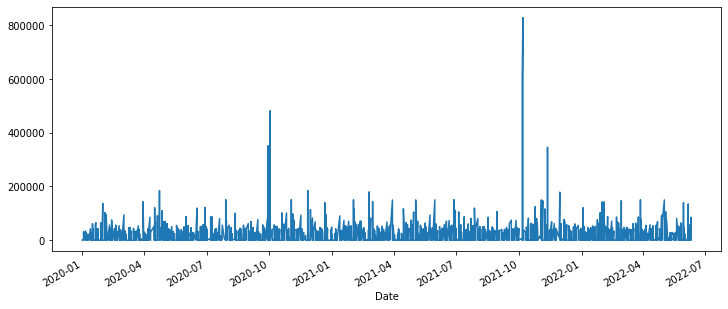

In [ ]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df_final['TranCount'].plot(figsize=(12,5))

To check to see if the data is statistically stationary, we run a adfuller test. If the p-value < 0.05 then the data is stationary, otherwise it isn't. As you can see below, it is less then 0.05, therefore we can confirm its stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)


ad_test(df_final['TranCount'])

1. ADF :  -10.622586432395575
2. P-Value :  5.466989908052055e-19
3. Num Of Lags :  26
4. Num Of Observations Used For ADF Regression: 4052
5. Critical Values :
	 1% :  -3.4319648685793593
	 5% :  -2.862253560551524
	 10% :  -2.5671498354486446


We simple supply our data to the auto_arima function. The function basically uses something called as the AIC score to judge how good a particular order model is. It simply tries to minimize the AIC score, and here’s how the output looks like:

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_final['TranCount'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic


We can see the best ARIMA model seems to be of the order ARIMA(5,0,2)(0,0,0) intercept with the minimum AIC = 95120.928. Now we can train our procedure with this type of model.

We now have to split the data set into a training and testing section. We do this because we first train the model on the data and keep the testing section hidden from the model. Once model is ready, we ask it to make predictions on the test data and see how well it performs.

In [ ]:
print('Before Split :', df_final.shape)
train=df_final.iloc[:-30]
test=df_final.iloc[-30:]
print('After Split :', train.shape, test.shape)

In [ ]:
import statsmodels.tsa.arima.model as sm

model = sm.ARIMA(train['TranCount'], order=(5,0,2))
model = model.fit()
model.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1

pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')

pred.plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test['TranCount'].mean()
rmse=sqrt(mean_squared_error(pred,test['TranCount']))
print(rmse)